In [ ]:
# !pip install easyocr requests pillow matplotlib

In [ ]:
# !pip install -U google-generativeai

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Classify groceries

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import os

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os

DATA_DIR = "/content/drive/MyDrive/foodguard/combined_data"
class_names = sorted(os.listdir(DATA_DIR))
num_classes = len(class_names)

print("Classes:", class_names)

model = resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model_path = "/content/drive/MyDrive/foodguard/models/classifiers/classifier_resnet50.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded!")

Classes: ['BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS', 'CHOCOLATE', 'COFFEE', 'CORN', 'FISH', 'FLOUR', 'HONEY', 'JAM', 'JUICE', 'MILK', 'NUTS', 'OIL', 'PASTA', 'RICE', 'SODA', 'SPICES', 'SUGAR', 'TEA', 'TOMATO_SAUCE', 'VINEGAR', 'WATER', 'apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Model loaded!


In [63]:
test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = test_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        pred_idx = outputs.argmax().item()
        pred_label = class_names[pred_idx]

    return pred_label


In [64]:
test_image_dir = "/content/drive/MyDrive/foodguard/data/integration_testing"

groceries_available = []

for filename in os.listdir(test_image_dir):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(test_image_dir, filename)
        pred = predict_image(path)
        groceries_available.append(pred)
        print(f"{filename} → {pred}")


pasta.png → PASTA
tomato sauce.png → TOMATO_SAUCE
spinach.jpg → spinach


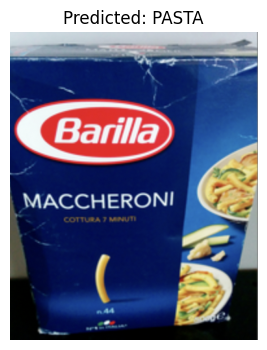

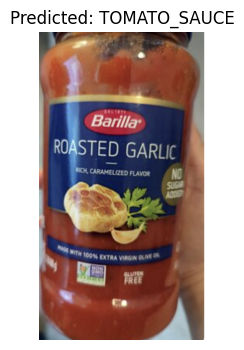

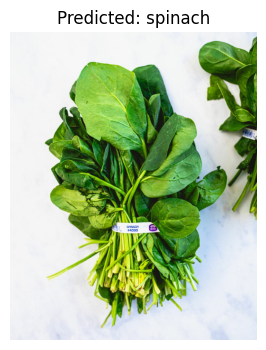

In [65]:
import matplotlib.pyplot as plt

for filename in os.listdir(test_image_dir):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(test_image_dir, filename)
        pred = predict_image(path)

        img = Image.open(path)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Predicted: {pred}")
        plt.show()


In [68]:
groceries_available

['PASTA', 'TOMATO_SAUCE', 'spinach']

## Get label

In [69]:
# ===============================
#   OCR + LABEL EXTRACTION MODULE
#   (Integrated from Get Label.ipynb)
# ===============================

import easyocr
import requests
import re
from difflib import get_close_matches

reader = easyocr.Reader(["en"], gpu=False)

def extract_ocr_text(img_path):
    results = reader.readtext(img_path, detail=0)
    return [t.strip() for t in results if len(t.strip()) > 0]

def clean_text_list(text_list):
    cleaned = []
    for t in text_list:
        t = t.lower()
        t = re.sub(r'[^a-zA-Z ]', ' ', t)
        t = t.strip()
        if len(t) > 1:
            cleaned.append(t)
    return cleaned

def is_valid_word(w):
    w = w.lower()
    if not w.isalpha():
        return False
    if len(w) < 3:
        return False
    # OCR garbage filters
    if re.search(r'(.)\1{2,}', w):
        return False
    if not re.match(r'^[a-z]+$', w):
        return False
    garbage = {"conu", "virumn", "noor", "aai"}  # reject known OCR artifacts
    if w in garbage:
        return False
    return True

STOPWORDS = {
    "and","with","the","made","from","rich","free","no","added",
    "premium","natural","quality","flavor","flavour",
    "fresh","extra","taste","original","best"
}

def detect_brand(ocr_text):
    if len(ocr_text) == 0:
        return None
    first = ocr_text[0].lower()
    first = re.sub(r'[^a-z]', '', first)
    return first

def extract_keywords(cleaned_list):
    keywords = []
    for text in cleaned_list:
        for w in text.split():
            w = w.lower()
            if w not in STOPWORDS and is_valid_word(w):
                keywords.append(w)
    return list(dict.fromkeys(keywords))

def build_search_query(ocr_text):
    cleaned = clean_text_list(ocr_text)
    brand = detect_brand(ocr_text)
    keywords = extract_keywords(cleaned)

    # ensure brand is included
    if brand and brand not in keywords:
        keywords.insert(0, brand)

    return " ".join(keywords[:3])

def search_openfoodfacts(query):
    url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": query,
        "search_simple": 1,
        "action": "process",
        "json": 1
    }
    return requests.get(url, params=params).json()

def extract_nutrition(product):
    n = product.get("nutriments", {})
    return {
        "calories_100g": n.get("energy-kcal_100g"),
        "fat_100g": n.get("fat_100g"),
        "saturated_fat_100g": n.get("saturated-fat_100g"),
        "carbs_100g": n.get("carbohydrates_100g"),
        "sugars_100g": n.get("sugars_100g"),
        "fiber_100g": n.get("fiber_100g"),
        "protein_100g": n.get("proteins_100g"),
        "salt_100g": n.get("salt_100g"),
    }

# def get_label_and_nutrition(img_path):
#     print("\n Extracting OCR text...")
#     ocr_raw = extract_ocr_text(img_path)
#     print("OCR:", ocr_raw)

#     print("\n Building search query...")
#     query = build_search_query(ocr_raw)
#     print("Query:", query)

#     print("\n Querying OpenFoodFacts...")
#     data = search_openfoodfacts(query)

#     if data.get("count", 0) == 0:
#         print(" No product found")
#         return None

#     product = data["products"][0]
#     nutrition = extract_nutrition(product)

#     print("\n NUTRITION INFORMATION")
#     for k, v in nutrition.items():
#         print(f"{k}: {v}")

#     return nutrition

def get_label_and_nutrition(img_path, fallback_name=None):
    print("\n Extracting OCR text...")
    ocr_raw = extract_ocr_text(img_path)
    print("OCR:", ocr_raw)

    # CASE 1 — OCR WORKED
    if ocr_raw and len([w for w in ocr_raw if w.strip()]) > 0:
        query = build_search_query(ocr_raw)
        print("\n Using OCR-based query:", query)

    else:
        # CASE 2 — OCR FAILED, fall back to classification name
        query = fallback_name.replace("_", " ").lower()
        print("\n No OCR text found — using fallback query:", query)

    print("\n Querying OpenFoodFacts...")
    data = search_openfoodfacts(query)

    # Handle API issues
    if not data or data.get("count", 0) == 0:
        print(" No valid product found for query:", query)
        return None

    product = data["products"][0]
    nutrition = extract_nutrition(product)

    print("\n NUTRITION INFORMATION:")
    for k, v in nutrition.items():
        print(f"{k}: {v}")

    return nutrition



In [ ]:
# ======================================================
#                 GET RECIPE MODULE
# ======================================================

import json
import google.generativeai as genai

# configure Gemini once
genai.configure(api_key="apikey")

def build_recipe_prompt(groceries):
    pretty = json.dumps(groceries, indent=2)
    prompt = f"""
You are a nutrition-aware recipe generator.
Here is my grocery inventory, with nutritional values per 100g:
{pretty}

Your tasks:
1. Create ONE recipe using the available groceries.
2. Prefer items that appear most relevant.
3. Give:
   - Recipe title
   - Ingredients list with quantities
   - Step-by-step instructions
4. Compute NUTRITION PER SERVING using the nutritional values above.
5. Output in strict JSON format:

{{
  "recipe_title": "...",
  "ingredients": [
      {{ "name": "...", "quantity_g": ... }},
      ...
  ],
  "steps": [
      "step 1...",
      "step 2..."
  ],
  "nutrition_per_serving": {{
      "calories": ...,
      "protein": ...,
      "carbs": ...,
      "fat": ...
  }}
}}
"""
    return prompt

def generate_recipe_from_groceries(grocery_items):
    """
    grocery_items must be a list of:
    {
        "item": <string>,
        "nutrition": { nutrition dict }
    }
    """
    prompt = build_recipe_prompt(grocery_items)
    model = genai.GenerativeModel("gemini-2.5-flash")

    response = model.generate_content(prompt)
    return response.text


In [ ]:
image_map = {}
groceries_available = []
nutrition_info = {}
recipe_input = []

for filename in os.listdir(test_image_dir):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):

        img_path = os.path.join(test_image_dir, filename)

        print("\n============================================")
        print(f"Processing: {filename}")
        print("============================================")

        # CLASSIFICATION
        predicted_class = predict_image(img_path)
        clean_name = predicted_class.replace("_", " ").title()

        if clean_name not in groceries_available:
            groceries_available.append(clean_name)

        print("Grocery detected:", clean_name)

        #SAVE IMAGE FOR THE INGREDIENT
        if clean_name not in image_map:
            image_map[clean_name] = img_path   

        #OCR + NUTRITION
        nutrition = get_label_and_nutrition(img_path, fallback_name=predicted_class)
        nutrition_info[filename] = nutrition

        if nutrition:
            if clean_name not in [item["item"] for item in recipe_input]:
                recipe_input.append({
                    "item": clean_name,
                    "nutrition": nutrition
                })



Processing: pasta.png
🛒 Grocery detected: Pasta

 Extracting OCR text...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR: ['Barilla', 'MACCHERONI', 'conu']

 Using OCR-based query: barilla maccheroni

 Querying OpenFoodFacts...

 NUTRITION INFORMATION:
calories_100g: 359
fat_100g: 2
saturated_fat_100g: 0.5
carbs_100g: 71
sugars_100g: 3.5
fiber_100g: 3
protein_100g: 13
salt_100g: 0.01

Processing: tomato sauce.png
🛒 Grocery detected: Tomato Sauce

 Extracting OCR text...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR: ['Barilla"', 'ROASTED GARLIC', 'RCH CARAMELIZED FLAYOR', 'No', 'S6', 'Aai', 'Fextra Virumn', 'FREE', 'm', 'Noor', '(ondo']

 Using OCR-based query: barilla roasted garlic

 Querying OpenFoodFacts...

 NUTRITION INFORMATION:
calories_100g: 36
fat_100g: 0.4
saturated_fat_100g: 0
carbs_100g: 8.8
sugars_100g: 4
fiber_100g: 2.4
protein_100g: 1.6
salt_100g: 0.82

Processing: spinach.jpg
🛒 Grocery detected: Spinach

 Extracting OCR text...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR: ['SPinach', '04090']

 Using OCR-based query: spinach

 Querying OpenFoodFacts...

 NUTRITION INFORMATION:
calories_100g: 276
fat_100g: 10.8
saturated_fat_100g: 4.5
carbs_100g: 34.2
sugars_100g: 3.5
fiber_100g: None
protein_100g: 9.2
salt_100g: 0.96


In [80]:
print("\n================ FINAL OUTPUT ================")

print("\n GROCERIES AVAILABLE:")
print(groceries_available)

print("\n NUTRITIONAL VALUES PER PRODUCT:")
print(nutrition_info)

print("\n GENERATING RECIPE...\n")
recipe = generate_recipe_from_groceries(recipe_input)

print(recipe)



================ FINAL OUTPUT ================

 GROCERIES AVAILABLE:
['Pasta', 'Tomato Sauce', 'Spinach']

 NUTRITIONAL VALUES PER PRODUCT:
{'pasta.png': {'calories_100g': 359, 'fat_100g': 2, 'saturated_fat_100g': 0.5, 'carbs_100g': 71, 'sugars_100g': 3.5, 'fiber_100g': 3, 'protein_100g': 13, 'salt_100g': 0.01}, 'tomato sauce.png': {'calories_100g': 36, 'fat_100g': 0.4, 'saturated_fat_100g': 0, 'carbs_100g': 8.8, 'sugars_100g': 4, 'fiber_100g': 2.4, 'protein_100g': 1.6, 'salt_100g': 0.82}, 'spinach.jpg': {'calories_100g': 276, 'fat_100g': 10.8, 'saturated_fat_100g': 4.5, 'carbs_100g': 34.2, 'sugars_100g': 3.5, 'fiber_100g': None, 'protein_100g': 9.2, 'salt_100g': 0.96}}

 GENERATING RECIPE...



ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 3749.29ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 1926.24ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 1040.70ms


```json
{
  "recipe_title": "Simple Spinach Tomato Pasta",
  "ingredients": [
    {
      "name": "Pasta",
      "quantity_g": 80
    },
    {
      "name": "Tomato Sauce",
      "quantity_g": 150
    },
    {
      "name": "Spinach",
      "quantity_g": 50
    }
  ],
  "steps": [
    "Bring a large pot of salted water to a boil.",
    "Add the pasta to the boiling water and cook according to package directions until al dente (usually 8-10 minutes).",
    "While the pasta is cooking, gently heat the tomato sauce in a saucepan over medium heat.",
    "Once the sauce is warm, add the spinach. Stir gently until the spinach is fully incorporated and heated through (approximately 2-3 minutes), given its dense nutritional profile.",
    "Once the pasta is cooked, drain it thoroughly.",
    "Combine the cooked pasta with the spinach tomato sauce. Toss well to ensure the pasta is evenly coated.",
    "Serve immediately and enjoy!"
  ],
  "nutrition_per_serving": {
    "calories": 479,
    "pro

In [84]:
image_map

{'Pasta': '/content/drive/MyDrive/foodguard/data/integration_testing/pasta.png',
 'Tomato Sauce': '/content/drive/MyDrive/foodguard/data/integration_testing/tomato sauce.png',
 'Spinach': '/content/drive/MyDrive/foodguard/data/integration_testing/spinach.jpg'}

In [82]:
clean_name = predicted_class.replace("_", " ").title()

# Store image path for the ingredient (first occurrence only)
if clean_name not in image_map:
    image_map[clean_name] = img_path

In [88]:
def display_recipe(recipe_json, image_map=None):
    import re
    import json
    import matplotlib.pyplot as plt
    from PIL import Image

    # -----------------------------
    # CLEAN GEMINI RESPONSE
    # -----------------------------
    cleaned = recipe_json.strip()
    cleaned = re.sub(r"```json", "", cleaned, flags=re.IGNORECASE)
    cleaned = re.sub(r"```", "", cleaned).strip()

    # -----------------------------
    # PARSE JSON
    # -----------------------------
    try:
        recipe = json.loads(cleaned)
    except:
        print("⚠️ Could not parse recipe JSON. Showing raw output:")
        print(cleaned)
        return

    title = recipe.get("recipe_title", "Recipe")
    ingredients = recipe.get("ingredients", [])
    steps = recipe.get("steps", [])
    nutrition = recipe.get("nutrition_per_serving", {})

    # -----------------------------
    # TEXT OUTPUT
    # -----------------------------
    print("\n" + "="*60)
    print(f"RECIPE: {title}")
    print("="*60)

    print("\n INGREDIENTS:")
    for ing in ingredients:
        print(f" • {ing['name']} — {ing['quantity_g']} g")

    print("\nSTEPS:")
    for i, step in enumerate(steps, 1):
        print(f" {i}. {step}")

    print("\n NUTRITION PER SERVING:")
    for k, v in nutrition.items():
        print(f" • {k.capitalize()}: {v}")

    # -----------------------------
    # SIDE-BY-SIDE IMAGES
    # -----------------------------
    if image_map:
        ingredient_names = [ing["name"] for ing in ingredients if ing["name"] in image_map]

        print("\n🖼️  INGREDIENT IMAGES:")

        num_items = len(ingredient_names)
        fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 4))

        # In case there's only one ingredient
        if num_items == 1:
            axes = [axes]

        for ax, name in zip(axes, ingredient_names):
            img_path = image_map[name]
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(name)
            ax.axis("off")

        plt.tight_layout()
        plt.show()



RECIPE: Simple Spinach Tomato Pasta

 INGREDIENTS:
 • Pasta — 80 g
 • Tomato Sauce — 150 g
 • Spinach — 50 g

STEPS:
 1. Bring a large pot of salted water to a boil.
 2. Add the pasta to the boiling water and cook according to package directions until al dente (usually 8-10 minutes).
 3. While the pasta is cooking, gently heat the tomato sauce in a saucepan over medium heat.
 4. Once the sauce is warm, add the spinach. Stir gently until the spinach is fully incorporated and heated through (approximately 2-3 minutes), given its dense nutritional profile.
 5. Once the pasta is cooked, drain it thoroughly.
 6. Combine the cooked pasta with the spinach tomato sauce. Toss well to ensure the pasta is evenly coated.
 7. Serve immediately and enjoy!

 NUTRITION PER SERVING:
 • Calories: 479
 • Protein: 17.4
 • Carbs: 87.1
 • Fat: 7.6

🖼️  INGREDIENT IMAGES:


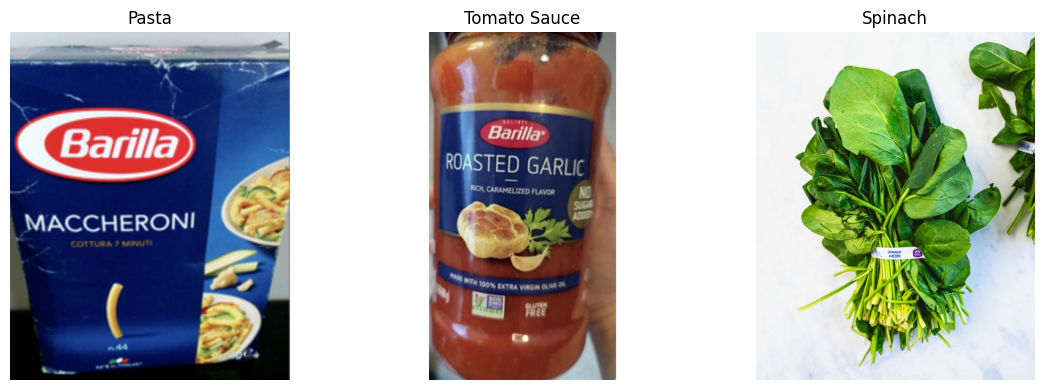

In [89]:
# recipe = generate_recipe_from_groceries(recipe_input)
display_recipe(recipe, image_map=image_map)